In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt


# origin is center of the court
three_d_keypoints = [
    (-10.97 / 2, 0, 23.77 / 2),
    (10.97 / 2, 0, 23.77 / 2),
    (-10.97 / 2, 0, -23.77 / 2),
    (10.97 / 2, 0, -23.77 / 2),
    (-8.23 / 2, 0, 23.77 / 2),
    (-8.23 / 2, 0, -23.77 / 2),
    (8.23 / 2, 0, 23.77 / 2),
    (8.23 / 2, 0, -23.77 / 2),
    (-8.23 / 2, 0, 6.4),
    (8.23 / 2, 0, 6.4),
    (-8.23 / 2, 0, -6.4),
    (8.23 / 2, 0, -6.4),
    (0, 0, 6.4),
    (0, 0, -6.4),
]


class ConvBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, pad=1, stride=1, bias=True
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride=stride,
                padding=pad,
                bias=bias,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.block(x)


class BallTrackerNet(nn.Module):
    def __init__(self, out_channels=14):
        super().__init__()
        self.out_channels = out_channels

        self.conv1 = ConvBlock(in_channels=3, out_channels=64)
        self.conv2 = ConvBlock(in_channels=64, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = ConvBlock(in_channels=64, out_channels=128)
        self.conv4 = ConvBlock(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = ConvBlock(in_channels=128, out_channels=256)
        self.conv6 = ConvBlock(in_channels=256, out_channels=256)
        self.conv7 = ConvBlock(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv8 = ConvBlock(in_channels=256, out_channels=512)
        self.conv9 = ConvBlock(in_channels=512, out_channels=512)
        self.conv10 = ConvBlock(in_channels=512, out_channels=512)
        self.ups1 = nn.Upsample(scale_factor=2)
        self.conv11 = ConvBlock(in_channels=512, out_channels=256)
        self.conv12 = ConvBlock(in_channels=256, out_channels=256)
        self.conv13 = ConvBlock(in_channels=256, out_channels=256)
        self.ups2 = nn.Upsample(scale_factor=2)
        self.conv14 = ConvBlock(in_channels=256, out_channels=128)
        self.conv15 = ConvBlock(in_channels=128, out_channels=128)
        self.ups3 = nn.Upsample(scale_factor=2)
        self.conv16 = ConvBlock(in_channels=128, out_channels=64)
        self.conv17 = ConvBlock(in_channels=64, out_channels=64)
        self.conv18 = ConvBlock(in_channels=64, out_channels=self.out_channels)

        self._init_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.ups1(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.ups2(x)
        x = self.conv14(x)
        x = self.conv15(x)
        x = self.ups3(x)
        x = self.conv16(x)
        x = self.conv17(x)
        x = self.conv18(x)
        return F.sigmoid(x)

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.uniform_(module.weight, -0.05, 0.05)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)


def postprocess(heatmap, scale=2, low_thresh=250, min_radius=10, max_radius=30):
    x_pred, y_pred = None, None
    ret, heatmap = cv2.threshold(heatmap, low_thresh, 255, cv2.THRESH_BINARY)
    circles = cv2.HoughCircles(
        heatmap,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=20,
        param1=50,
        param2=5,
        minRadius=10,
    )
    if circles is not None:
        x_pred = circles[0][0][0] * scale
        y_pred = circles[0][0][1] * scale
    return x_pred, y_pred


def get_keypoints(preds: torch.Tensor):
    points = []
    for kps_num in range(14):
        heatmap = (preds[kps_num] * 255).astype(np.uint8)
        x_pred, y_pred = postprocess(heatmap, scale=1, low_thresh=170, max_radius=25)
        points.append((x_pred, y_pred))
    return points


class tracknet_transform(torch.nn.Module):
    def __init__(
        self,
        size: tuple,
    ) -> None:
        self.img_size = size

    def __call__(self, img_path: str) -> torch.Tensor:
        image = Image.open(img_path).convert("RGB").resize(self.img_size)
        image = torch.from_numpy(np.array(image) / 255.0).float()
        image = image.permute(2, 0, 1)
        return image


def refine_keypoints(keypoints: list, image: np.ndarray, window_size=20):
    """
    Refines keypoints by finding the centroid of line intersections.
    Robust to thick/pixelated lines.

    Args:
        keypoints: List of (x, y) tuples from initial detection
        image: Original image as numpy array (H, W, 3)
        window_size: Size of the window to search around each keypoint

    Returns:
        List of refined (x, y) tuples
    """
    refined_keypoints = []

    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    h, w = gray.shape

    for x_pred, y_pred in keypoints[:]:
        if x_pred is None or y_pred is None:
            refined_keypoints.append((None, None))
            continue

        x_pred, y_pred = int(x_pred), int(y_pred)

        x_min = max(0, x_pred - window_size)
        x_max = min(w, x_pred + window_size)
        y_min = max(0, y_pred - window_size)
        y_max = min(h, y_pred + window_size)

        window = gray[y_min:y_max, x_min:x_max]

        if window.size == 0:
            refined_keypoints.append((x_pred, y_pred))
            continue

        _, binary = cv2.threshold(window * 255, 200, 255, cv2.THRESH_BINARY)
        skeleton = binary

        corners = cv2.goodFeaturesToTrack(
            skeleton, maxCorners=5, qualityLevel=0.01, minDistance=5, blockSize=3
        )

        if corners is not None and len(corners) > 0:
            center_x, center_y = window.shape[1] // 2, window.shape[0] // 2
            corners = corners.reshape(-1, 2)
            closest = min(
                corners, key=lambda p: (p[0] - center_x) ** 2 + (p[1] - center_y) ** 2
            )
            refined_x = closest[0] + x_min
            refined_y = closest[1] + y_min
            refined_keypoints.append((refined_x, refined_y))
        else:
            center_x, center_y = window.shape[1] // 2, window.shape[0] // 2
            y_coords, x_coords = np.where(binary > 0)

            if len(x_coords) > 0:
                # Calculate weights based on distance to center
                distances = np.sqrt(
                    (x_coords - center_x) ** 2 + (y_coords - center_y) ** 2
                )
                weights = np.exp(-distances / 10)  # Gaussian weighting

                # Weighted centroid
                centroid_x = np.average(x_coords, weights=weights)
                centroid_y = np.average(y_coords, weights=weights)

                refined_x = centroid_x + x_min
                refined_y = centroid_y + y_min
                refined_keypoints.append((refined_x, refined_y))
            else:
                refined_keypoints.append((x_pred, y_pred))
    return refined_keypoints


def estimate_focal_range(image_width, image_height):
    """Conservative search range"""

    # Assume FOV between 30° and 90°
    min_f = image_width / (2 * np.tan(np.radians(90) / 2))  # Wide
    max_f = image_width / (2 * np.tan(np.radians(30) / 2))  # Narrow

    # Add 20% margin
    min_f *= 0.8
    max_f *= 1.2

    return min_f, max_f


def solve_pnp_with_focal_search(
    object_points, image_points, focal_range=(500, 2000), principal_point=None
):
    """
    object_points: Nx3 array of 3D points
    image_points: Nx2 array of 2D image points
    focal_range: (min_f, max_f) to search
    """
    if principal_point is None:
        principal_point = (image_points[:, 0].mean(), image_points[:, 1].mean())

    best_f = None
    best_error = float("inf")
    best_pose = None

    # Try different focal lengths
    for f in np.linspace(focal_range[0], focal_range[1], 50):
        camera_matrix = np.array(
            [[f, 0, principal_point[0]], [0, f, principal_point[1]], [0, 0, 1]],
            dtype=np.float32,
        )

        # Solve PnP - this returns multiple solutions for coplanar points
        success, rvec, tvec = cv2.solvePnP(
            object_points,
            image_points,
            camera_matrix,
            None,  # no distortion
            flags=cv2.SOLVEPNP_IPPE,  # Good for planar points
        )

        if success:
            # Compute reprojection error
            projected, _ = cv2.projectPoints(
                object_points, rvec, tvec, camera_matrix, None
            )
            error = np.mean(np.linalg.norm(projected.squeeze() - image_points, axis=1))

            if error < best_error:
                best_error = error
                best_f = f
                best_pose = (rvec, tvec)

    return best_f, best_pose, best_error

def get_points(keypoints: list):
    points_2d = []
    points_3d = []
    for idx, keypoint in enumerate(keypoints):
        if keypoint[0] is not None and keypoint[1] is not None:
            points_2d.append(keypoint)
            points_3d.append(three_d_keypoints[idx])
    return np.array(points_2d), np.array(points_3d)

def plot_keypoints(keypoints: list, image: np.ndarray):
    for idx, keypoint in enumerate(keypoints):
        if keypoint[0] is not None and keypoint[1] is not None:
            # plot text
            cv2.putText(image, str(idx), (int(keypoint[0]), int(keypoint[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
            cv2.circle(image, (int(keypoint[0]), int(keypoint[1])), 5, (0, 0, 255), -1)
    return image

def solve_planar_pnp(object_points, image_points, camera_matrix):
    """Handles the planar ambiguity explicitly"""
    
    # IPPE returns both possible solutions
    success, rvecs, tvecs, reprojErrors = cv2.solvePnPGeneric(
        object_points,
        image_points,
        camera_matrix,
        None,
        flags=cv2.SOLVEPNP_IPPE
    )
    
    # You'll get 2 solutions - pick based on physical constraints
    # e.g., camera should be in front of points, not behind
    for i, (rvec, tvec) in enumerate(zip(rvecs, tvecs)):
        print(f"Solution {i}:")
        print(f"  Rotation: {rvec.ravel()}")
        print(f"  Translation: {tvec.ravel()}")
        print(f"  Reprojection error: {reprojErrors[i]}")
    
    return rvecs, tvecs, reprojErrors

def get_camera_pose_in_world(rvec, tvec):
    """Get camera position in world coordinates"""
    R, _ = cv2.Rodrigues(rvec)  # Convert axis-angle to rotation matrix
    
    # Camera position in world frame
    camera_position = -R.T @ tvec
    
    # Camera orientation in world frame
    R_world = R.T  # Rotation from camera to world
    
    return camera_position, R_world

def rvec_tvec_to_extrinsic(rvec, tvec):
    R, _ = cv2.Rodrigues(rvec)
    extrinsic_3x4 = np.hstack([R, tvec.reshape(3, 1)])
    
    return extrinsic_3x4

def select_valid_solution(rvecs, tvecs, reprojErrors):
    """Select the solution where camera is above the court (positive Y)"""
    
    for i, (rvec, tvec) in enumerate(zip(rvecs, tvecs)):
        camera_pos, _ = get_camera_pose_in_world(rvec, tvec)
        
        # For tennis court: camera should be above ground (Y > 0)
        # and in front of court (reasonable Z value)
        if camera_pos[2] < 0:  # camera is behind the court
            print(f"Selected solution {i}: Camera at {camera_pos.ravel()}")
            return rvec, tvec, reprojErrors[i]
    
    # Fallback to lowest reprojection error
    best_idx = np.argmin(reprojErrors)
    return rvecs[best_idx], tvecs[best_idx], reprojErrors[best_idx]


In [304]:
device = "cpu"
MODEL_PATH = "/Users/derek/Desktop/sports_3d/checkpoints/model_tennis_court_det.pt"
model = BallTrackerNet(out_channels=15)
model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
model.eval()
model = model.to(device)

im_path = (
    "/Users/derek/Desktop/sports_3d/data/Screenshot 2025-11-23 at 2.37.22 PM.png"
)

transform = tracknet_transform(size=(int(640), int(360)))
image = transform(im_path)
image = image.unsqueeze(0)
image = image.to(device)
preds = model(image)
keypoints = get_keypoints(preds[0].cpu().detach().numpy())
refined_keypoints = refine_keypoints(
    keypoints, image[0].cpu().detach().numpy().transpose(1, 2, 0)
)
print(refined_keypoints)
refined_keypoints = [
    refined_keypoints[0],
    refined_keypoints[2],
    refined_keypoints[4],
    refined_keypoints[5],
    refined_keypoints[10]
]

[(np.float32(160.0), np.float32(113.0)), (np.float32(291.0), np.float32(126.0)), (np.float32(44.0), np.float32(267.0)), (None, None), (np.float32(192.0), np.float32(110.0)), (np.float32(141.0), np.float32(261.0)), (np.float32(291.0), np.float32(126.0)), (np.float32(331.0), np.float32(186.0)), (np.float32(188.0), np.float32(122.0)), (None, None), (np.float32(162.0), np.float32(195.0)), (None, None), (None, None), (np.float32(533.0), np.float32(263.0))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


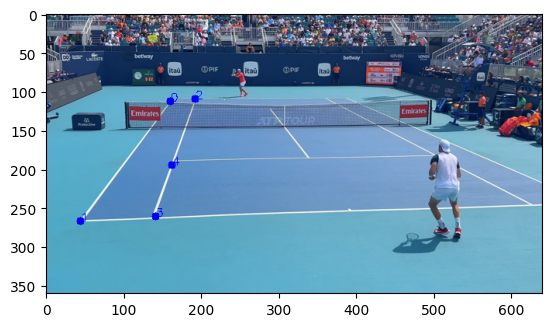

In [301]:
plt.imshow(plot_keypoints(refined_keypoints, image[0].cpu().detach().numpy().transpose(1, 2, 0)))

In [310]:
points_2d = refined_keypoints
points_3d = [
    three_d_keypoints[0],
    three_d_keypoints[2],
    three_d_keypoints[4],
    three_d_keypoints[5],
    three_d_keypoints[10]
]
points_2d = np.array(points_2d)
points_3d = np.array(points_3d)
min_f, max_f = estimate_focal_range(image.shape[2], image.shape[1])

best_f, best_pose, best_error = solve_pnp_with_focal_search(
points_3d, points_2d, focal_range=(min_f, max_f), principal_point=(image[0].shape[2] / 2, image[0].shape[1] / 2)
)
camera_matrix = np.array(
    [[best_f, 0, image[0].shape[2] / 2], [0, best_f, image[0].shape[1] / 2], [0, 0, 1]],
    dtype=np.float32,
)
rvecs, tvecs, errors = solve_planar_pnp(points_3d, points_2d, camera_matrix)
rvec, tvec, error = select_valid_solution(rvecs, tvecs, errors)
camera_pos, R_world = get_camera_pose_in_world(rvec, tvec)
extrinsic_matrix = rvec_tvec_to_extrinsic(rvec, tvec)


Solution 0:
  Rotation: [ 0.18104249 -0.11909984 -0.05479815]
  Translation: [-0.02981325 -1.16403478 23.89830093]
  Reprojection error: [1.73086796]
Solution 1:
  Rotation: [ 2.99418059 -0.1313602   0.42459062]
  Translation: [ 1.32182999  0.53846835 13.77783265]
  Reprojection error: [285.06077252]
[[ -2.75078501]
 [ -3.22373276]
 [-23.54836262]]
[[-5.10671546]
 [-0.72407603]
 [12.85546679]]


In [ ]:
image_width * 0.03

640

In [322]:
tennis_ball_width = 0.067  # meters
image_width = image.shape[3]
image_height = image.shape[2]

# Ball center in normalized coordinates
cx_normalized = 0.359950
cy_normalized = 0.309791

# Convert to pixel coordinates
cx_pixels = cx_normalized * image_width
cy_pixels = cy_normalized * image_height

# Ball width in pixels (assuming 0.04 is the fraction of image width)
ball_width_pixels = image_width * 0.0028

# Calculate depth using the width formula
z_cam = (tennis_ball_width * best_f) / ball_width_pixels

print(f"Depth (Z): {z_cam:.2f} meters")

# Now back-project to 3D camera coordinates using the depth
# Assuming principal point is at image center
cx_principal = image_width / 2
cy_principal = image_height / 2

# Back-project using the depth
x_cam = (cx_pixels - cx_principal) * z_cam / best_f
y_cam = (cy_pixels - cy_principal) * z_cam / best_f

print(f"Camera coords: X={x_cam:.2f}, Y={y_cam:.2f}, Z={z_cam:.2f}")

# Transform to world coordinates
p_cam = np.array([x_cam, y_cam, z_cam])
r = extrinsic_matrix[:3, :3]
t = extrinsic_matrix[:3, 3]
p_world = r.T @ (p_cam - t)

print(f"World coords: {p_world}")

Depth (Z): 30.14 meters
Camera coords: X=-3.35, Y=-2.56, Z=30.14
World coords: [-2.49576122 -0.37526209  6.7502225 ]


In [298]:
camera_pos

array([[ -2.75078501],
       [ -3.22373276],
       [-23.54836262]])

In [291]:
extrinsic_matrix = rvec_tvec_to_extrinsic(rvecs[0], tvecs[0])
intrinsic_matrix = camera_matrix
print(extrinsic_matrix)
print(intrinsic_matrix)

[[ 0.99144192  0.04360672 -0.12305031 -0.02981325]
 [-0.06507922  0.98218475 -0.17628899 -1.16403478]
 [ 0.11317075  0.18278831  0.97661703 23.89830093]]
[[806.123   0.    320.   ]
 [  0.    806.123 180.   ]
 [  0.      0.      1.   ]]


In [294]:
get_camera_pose_in_world(rvecs[0], tvecs[0])

(array([[ -2.75078501],
        [ -3.22373276],
        [-23.54836262]]),
 array([[ 0.99144192, -0.06507922,  0.11317075],
        [ 0.04360672,  0.98218475,  0.18278831],
        [-0.12305031, -0.17628899,  0.97661703]]))

In [292]:
print(points_2d)
print(points_3d)

[[160. 113.]
 [ 44. 267.]
 [192. 110.]
 [141. 261.]
 [162. 195.]]
[[ -5.485   0.     11.885]
 [ -5.485   0.    -11.885]
 [ -4.115   0.     11.885]
 [ -4.115   0.    -11.885]
 [ -4.115   0.     -6.4  ]]


In [293]:
world_points_homogeneous = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
print(world_points_homogeneous)
image_points_homogeneous = intrinsic_matrix @ extrinsic_matrix @ world_points_homogeneous.T
image_points_homogeneous = image_points_homogeneous.T
image_points_homogeneous = image_points_homogeneous[:, :2] / image_points_homogeneous[:, 2:3]
image_points_homogeneous

[[ -5.485   0.     11.885   1.   ]
 [ -5.485   0.    -11.885   1.   ]
 [ -4.115   0.     11.885   1.   ]
 [ -4.115   0.    -11.885   1.   ]
 [ -4.115   0.     -6.4     1.   ]]


array([[159.8523739 , 112.93364657],
       [ 43.33062403, 268.97524951],
       [191.80947019, 111.17922177],
       [139.54913425, 261.73092633],
       [164.14147353, 190.88525473]])